## Inundation
This notebook detects water and computes inundation frequency from yearly Sentinel-1 VV and VH minimum images
The final product is a frequency raster: each pixel’s count of years classified as water.

In [1]:
import os
import glob
import rioxarray as rxr
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter
from skimage .filters import threshold_otsu

#### Filtering
Define two functions:  
* lee_filter: applies Lee speckle filter on a 2D array  
* speckle_filter: applies it band-wise to an xarray Dataset (handles NaNs)  

In [2]:
#defining a function to apply lee filtering on S1 image
def lee_filter(img, size):
    """
    Apply Lee filter with specified window size.
    Adapted from https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python

    Parameters
        img(np.ndarray) :Input image (2D array).
        size (int): Window size (e.g., 5, 7).

    Returns
        np.ndarray: Speckle-filtered image.
    """
    img_mean = uniform_filter(img, size)
    img_sqr_mean = uniform_filter(img ** 2, size)
    img_variance = img_sqr_mean - img_mean ** 2

    # Estimate overall variance from image
    overall_variance = np.mean(img_variance)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)

    return img_output

def speckle_filter(ds, method = 'lee', size=7):
    """
    Apply Lee speckle filtering to all bands in an xarray Dataset.

    This function handles NaNs properly and applies the filter band-wise.
    Uses xarray.apply_ufunc to vectorize the operation and support dask.

    Parameters
        ds (xarray.Dataset): Input dataset with SAR bands (e.g. 'VV' and 'VH')
        method (str, optional): Filtering method ('lee' supported, default).
        size (int, optional): Window size for filtering (default: 7).

    Returns
        xarray.Dataset : Dataset with new variables '{band}_filtered'.
    """
    filtered_vars = {}
    for band in ds.data_vars:
        arr = ds[band]
        valid_mask = np.isfinite(arr) # mask valid data only
        arr_filled = arr.fillna(0)  # fill NaNs for processing
        
        # Apply Lee filter using xarray.apply_ufunc
        filtered = xr.apply_ufunc(
            lee_filter,
            arr_filled,
            kwargs={'size': size},
            input_core_dims=[list(arr.dims)],   # adjust if dimensions are ('y','x')
            output_core_dims=[list(arr.dims)],
            vectorize=True,
            dask='parallelized',
            output_dtypes=[arr.dtype]
        )
        filtered = filtered.where(valid_mask)   # Restore original NaNs
        filtered_vars[f"{band}_filtered"] = filtered

    return ds.assign(**filtered_vars)

Defines water classification.  

In [3]:
def classify_water(ds_filtered, vv_thresh: float = None, vh_thresh: float = None):
    """
    Classify water pixels based on thresholds for VV and VH polarizations.
    If thresholds are None, compute Otsu thresholds from the data.

    Parameters
    ----------
    ds_filtered : xr.Dataset
        Dataset containing filtered SAR bands: 'vv_filtered' and 'vh_filtered'.
    vv_thresh : float or None, optional
        Threshold for VV band to classify water. If None, computed via Otsu (default None).
    vh_thresh : float or None, optional
        Threshold for VH band to classify water. If None, computed via Otsu (default None).

    Returns
    -------
    xr.DataArray
        Binary mask (uint8) where 1 = water, 0 = non-water.
    """
    def compute_otsu_threshold(arr):
        valid_vals = arr.values.flatten()
        valid_vals = valid_vals[np.isfinite(valid_vals)]
        return threshold_otsu(valid_vals)

    if vv_thresh is None:
        vv_thresh = compute_otsu_threshold(ds_filtered['vv_filtered'])
    if vh_thresh is None:
        vh_thresh = compute_otsu_threshold(ds_filtered['vh_filtered'])

    print(f"[INFO] Otsu thresholds: VV={vv_thresh:.2f} dB, VH={vh_thresh:.2f} dB")

    water_vv = ds_filtered['vv_filtered'] < vv_thresh
    water_vh = ds_filtered['vh_filtered'] < vh_thresh
    water_mask = (water_vv | water_vh).astype(np.uint8)

    return water_mask


Loop through yearly VV & VH rasters:  
* Apply speckle filter
* Classify water
* Stack results to compute frequency

In [4]:
# Set input directories containing your Sentinel-1 VV and VH TIFF files
vv_folder = r"C:\Users\Ethel Ogallo\Documents\ZFL1\Data\input\S1_VV"
vh_folder = r"C:\Users\Ethel Ogallo\Documents\ZFL1\Data\input\S1_VH"

# Find and sort files to ensure matching pairs
vv_files = sorted(glob.glob(os.path.join(vv_folder, 'S1_VV_Min_2*.tif')))
vh_files = sorted(glob.glob(os.path.join(vh_folder, 'S1_VH_Min_2*.tif')))

assert len(vv_files) == len(vh_files), "Number of VV and VH files do not match!"

water_masks = []
years = []

for vv_file, vh_file in zip(vv_files, vh_files):
    year = int(os.path.basename(vv_file)[-8:-4])
    years.append(year)

    # Load VV and VH bands as masked DataArrays (no-data => NaN)
    vv_img = rxr.open_rasterio(vv_file, masked=True).squeeze()
    vh_img = rxr.open_rasterio(vh_file, masked=True).squeeze()
    ds = xr.Dataset({"vv": vv_img, "vh": vh_img})

    # Apply Lee speckle filtering
    ds_filtered = speckle_filter(ds, size=7)

    # Classify water pixels using thresholds
    water_mask = classify_water(ds_filtered)
    water_mask = water_mask.assign_coords(time=year)

    water_masks.append(water_mask)

# Stack all yearly water masks along new 'time' dimension
stacked = xr.concat(water_masks, dim='time')

# Calculate how many times each pixel was classified as water
inundation_freq = stacked.sum(dim='time')


[INFO] Otsu thresholds: VV=-15.11 dB, VH=-23.54 dB
[INFO] Otsu thresholds: VV=-19.95 dB, VH=-25.68 dB
[INFO] Otsu thresholds: VV=-17.02 dB, VH=-29.47 dB
[INFO] Otsu thresholds: VV=-21.03 dB, VH=-31.82 dB
[INFO] Otsu thresholds: VV=-21.73 dB, VH=-30.98 dB
[INFO] Otsu thresholds: VV=-20.72 dB, VH=-27.20 dB
[INFO] Otsu thresholds: VV=-20.74 dB, VH=-23.95 dB
[INFO] Otsu thresholds: VV=-20.32 dB, VH=-23.87 dB
[INFO] Otsu thresholds: VV=-20.14 dB, VH=-30.88 dB
[INFO] Otsu thresholds: VV=-21.74 dB, VH=-32.53 dB
[INFO] Otsu thresholds: VV=-20.32 dB, VH=-31.47 dB


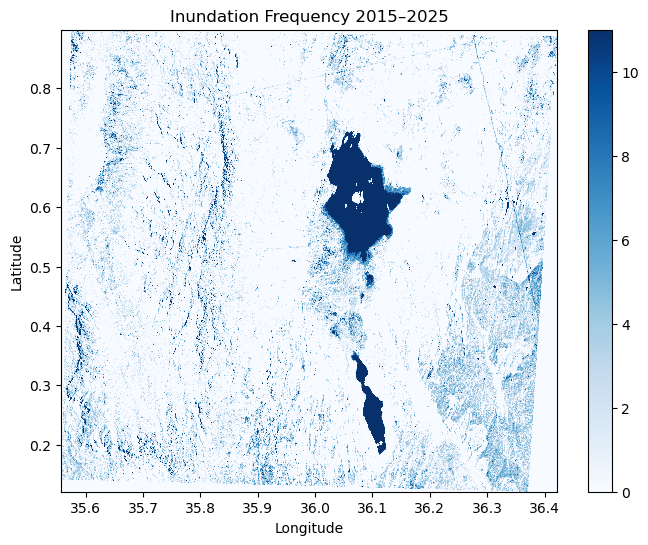

In [6]:
plt.figure(figsize=(8, 6))
inundation_freq.plot(cmap='Blues', vmin=0, vmax=len(years))
plt.title(f'Inundation Frequency {min(years)}–{max(years)}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [7]:
output_path = r"C:\Users\Ethel Ogallo\Documents\ZFL1\Data\processed_data\inundation_frequency.tif"
inundation_freq.rio.to_raster(output_path)
print(f"Saved inundation frequency GeoTIFF to:\n{output_path}")


Saved inundation frequency GeoTIFF to:
C:\Users\Ethel Ogallo\Documents\ZFL1\Data\processed_data\inundation_frequency.tif
